# Enhancement Showcase
This section is to showcase the difference of the base model with the model with enhancement.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from CustomGlucoseDynamicsEnv import CustomGlucoseDynamicsEnv
from DigitalTwinModel import DigitalTwinModel
from HybridLookaheadPolicyWrapper import HybridLookaheadPolicyWrapper

def action_to_text(action, twin, step_minutes=5):
    meal_cat, mode, intensity, duration = twin._continuous_to_discrete(action)

    meal_texts = [
        "No meal (just water, tea, or fasting)",
        "Light snack – about 30g carbs (e.g., 1–2 slices of bread, a piece of fruit, or yogurt)",
        "Regular meal – about 60g carbs (e.g., rice or pasta plate, sandwich with sides, balanced lunch/dinner)",
        "Heavy meal – about 90g+ carbs (e.g., large pasta dish, fast food combo, festive or multi-course meal)",
    ]

    exercise_texts = [
        "Resting / relaxing",
        "Light activity (walking, light chores)",
        "Moderate activity (brisk walk, cycling)",
        "Intense activity (running, sports)",
    ]

    parts = []
    if meal_cat > 0:
        parts.append(meal_texts[meal_cat])
    if mode == 1:
        parts.append(f"{exercise_texts[intensity]} for {duration*step_minutes} min")
    if not parts:
        parts.append("Maintain routine")

    return ", ".join(parts)

# --- Simulation setup ---
STEP_MINUTES = 5
SIMULATION_MINUTES = 1440  # full day
TOTAL_STEPS = SIMULATION_MINUTES // STEP_MINUTES

# user params
weight, Gb, Ib = 70, 90, 5.7
meal_schedule = {
    "breakfast": 8 * 60,
    "lunch": 13 * 60,
    "dinner": 19 * 60,
}

# inject events
hypo_step = 50
hyper_step = 150
freeze_steps = 3

# --- Load PPO baseline ---
model = PPO.load("ppo_best_glucose_model.zip")

# --- Setup environment & planner ---
env = CustomGlucoseDynamicsEnv(random_events=False, weight=weight, Gb=Gb, Ib=Ib)
obs, _ = env.reset()

twin = DigitalTwinModel(weight=weight, Gb=Gb, Ib=Ib, dt=STEP_MINUTES)
planner = HybridLookaheadPolicyWrapper(model=model, digital_twin=twin,
                                       horizon=6, candidates=5, target_glucose=100.0)

# --- Run single trajectory while logging both model predictions ---
records = []
freeze_counter, injected_glucose = 0, None

for step in range(TOTAL_STEPS):
    current_time = step * STEP_MINUTES

    # injections
    if step == hypo_step:
        injected_glucose = 30.0
        env.simulator_state[0] = injected_glucose
        env.simulator_state[7] *= 2
        freeze_counter = freeze_steps
        obs = env.refresh_observation()
        event = "hypoglycemia"
    elif step == hyper_step:
        injected_glucose = 300.0
        env.simulator_state[0] = injected_glucose
        env.simulator_state[5] = 0.0
        freeze_counter = freeze_steps
        obs = env.refresh_observation()
        event = "hyperglycemia"
    else:
        event = None

    # both model predictions 
    ppo_action, _ = model.predict(obs, deterministic=True)
    planner_action, _ = planner.predict(obs, env_state=env.clone_state(), deterministic=True)

    records.append({
        "time_min": current_time,
        "glucose": obs[0],
        "ppo_action": action_to_text(ppo_action, twin, step_minutes=STEP_MINUTES),
        "planner_action": action_to_text(planner_action, twin, step_minutes=STEP_MINUTES),
        "event": event
    })

    # advance env only once
    if freeze_counter > 0:
        obs[0] = injected_glucose
        freeze_counter -= 1
    else:
        for meal_name, meal_time in meal_schedule.items():
            if current_time == meal_time:
                obs, _, _, _, _ = env.force_action(meal_category=3)
                twin.sync_from_env_state(env.clone_state())
                event = meal_name
                break
        else:
            obs, _, _, _, _ = env.step(planner_action) 
            twin.sync_from_env_state(env.clone_state())

# --- Convert to DataFrame ---
df = pd.DataFrame(records)

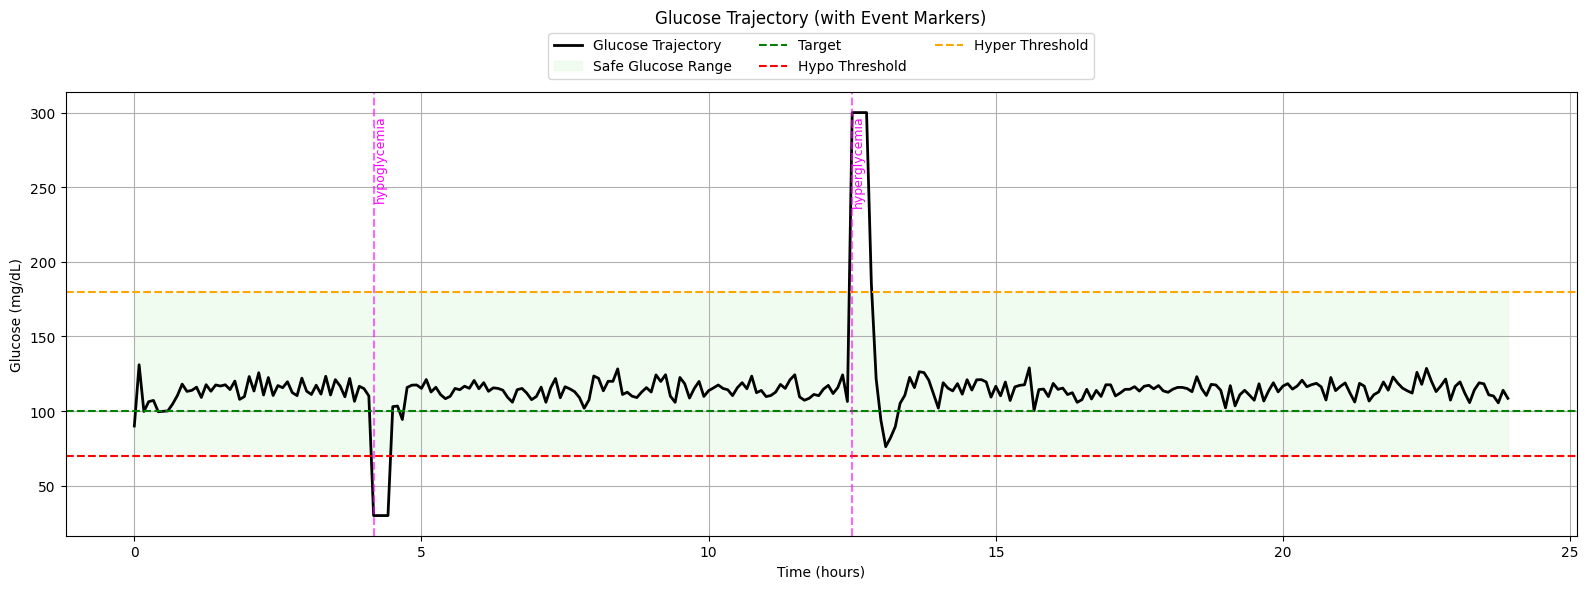

In [11]:
# --- Plot glucose trajectory ---
plt.figure(figsize=(16, 6))
plt.plot(df["time_min"]/60, df["glucose"], label="Glucose Trajectory", color="black", linewidth=2)

# safe range + thresholds
plt.fill_between(df["time_min"]/60, planner.SAFE_LOW, planner.SAFE_HIGH, 
                 color="#d3f8d3", alpha=0.3, label="Safe Glucose Range")
plt.axhline(100, color="green", linestyle="--", linewidth=1.5, label="Target")
plt.axhline(planner.SAFE_LOW, color="red", linestyle="--", linewidth=1.5, label="Hypo Threshold")
plt.axhline(planner.SAFE_HIGH, color="orange", linestyle="--", linewidth=1.5, label="Hyper Threshold")

# --- Event markers ---
ymin, ymax = plt.ylim()
label_y = ymax - 0.05 * (ymax - ymin)

for _, row in df[df["event"].notna()].iterrows():
    t_hr = row["time_min"] / 60
    plt.axvline(t_hr, color="magenta", linestyle="--", alpha=0.6)
    plt.text(t_hr, label_y, row["event"], rotation=90, fontsize=9,
             color="magenta", verticalalignment="top")

# labels
plt.xlabel("Time (hours)")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose Trajectory (with Event Markers)", pad=50)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# find exact times of injections
hypo_time  = df.loc[df["event"] == "hypoglycemia", "time_min"].values[0]
hyper_time = df.loc[df["event"] == "hyperglycemia", "time_min"].values[0]

# window size
window = 20  

df_hypo_window = df[(df["time_min"] >= hypo_time - window) & (df["time_min"] <= hypo_time + window)]
df_hyper_window = df[(df["time_min"] >= hyper_time - window) & (df["time_min"] <= hyper_time + window)]

display(df_hypo_window)
display(df_hyper_window)

,time_min,glucose,ppo_action,planner_action,event
46,230,106.547379,Maintain routine,Maintain routine,None
47,235,116.635971,Maintain routine,Maintain routine,None
48,240,115.016937,Maintain routine,Maintain routine,None
49,245,110.175804,Maintain routine,Maintain routine,None
50,250,30.000000,Maintain routine,"Regular meal – about 60g carbs (e.g., rice or ...",hypoglycemia
51,255,30.000000,Maintain routine,"Regular meal – about 60g carbs (e.g., rice or ...",None
52,260,30.000000,Maintain routine,"Regular meal – about 60g carbs (e.g., rice or ...",None
53,265,30.000000,Maintain routine,"Regular meal – about 60g carbs (e.g., rice or ...",None
54,270,102.984268,Maintain routine,Maintain routine,None


,time_min,glucose,ppo_action,planner_action,event
146,730,111.770668,Maintain routine,Maintain routine,None
147,735,115.802017,Maintain routine,Maintain routine,None
148,740,124.246933,Maintain routine,Maintain routine,None
149,745,106.421761,Maintain routine,Maintain routine,None
150,750,300.000000,"Intense activity (running, sports) for 60 min","Moderate activity (brisk walk, cycling) for 15...",hyperglycemia
151,755,300.000000,"Intense activity (running, sports) for 60 min","Moderate activity (brisk walk, cycling) for 15...",None
152,760,300.000000,"Intense activity (running, sports) for 60 min","Moderate activity (brisk walk, cycling) for 15...",None
153,765,300.000000,"Intense activity (running, sports) for 60 min","Moderate activity (brisk walk, cycling) for 15...",None
154,770,185.367142,"Intense activity (running, sports) for 60 min","Light activity (walking, light chores) for 15 min",None


In [ ]:
from tabulate import tabulate

print(tabulate(df_hypo_window, headers="keys", tablefmt="github"))
print(tabulate(df_hyper_window, headers="keys", tablefmt="github"))

|    |   time_min |   glucose | ppo_action       | planner_action                                                                                         | event        |
|----|------------|-----------|------------------|--------------------------------------------------------------------------------------------------------|--------------|
| 46 |        230 |   106.547 | Maintain routine | Maintain routine                                                                                       |              |
| 47 |        235 |   116.636 | Maintain routine | Maintain routine                                                                                       |              |
| 48 |        240 |   115.017 | Maintain routine | Maintain routine                                                                                       |              |
| 49 |        245 |   110.176 | Maintain routine | Maintain routine                                                                              